# 6. How to Solve ODEs with Rate Law Functions

Although the `ode` solver accepts `NetworkModel`, `ode.ODESimulator` owns its model class `ode.ODENetworkModel` and `ode.ODEReactionRule` for the extension. The interface of these classes are almost same with `Model` classes and `ReactionRule`. Here, we explain the usage specific to `ode` especially about `ode.ODERatelaw`.

In [1]:
%matplotlib inline
from ecell4 import *

However, the rate law support in `ode` is under development. Some functions might be deprecated in the future. Currently, to enable rate laws, the option `ecell4.util.decorator.ENABLE_RATELAW` must be activated as follows:

In [2]:
util.decorator.ENABLE_RATELAW = True

## 6.1. ode.ODEReactionRule

`ode.ODEReactionRule` has almost same members with `ReactionRule`.

In [3]:
rr1 = ReactionRule()
rr1.add_reactant(Species("A"))
rr1.add_reactant(Species("B"))
rr1.add_product(Species("C"))
rr1.set_k(1.0)
print(len(rr1.reactants()))  # => 2
print(len(rr1.products()))  # => 1
print(rr1.k())  # => 1.0
print(rr1.as_string())  # => A+B>C|1

2
1
1.0
A+B>C|1


In [4]:
rr2 = ode.ODEReactionRule()
rr2.add_reactant(Species("A"))
rr2.add_reactant(Species("B"))
rr2.add_product(Species("C"))
rr2.set_k(1.0)
print(len(rr2.reactants()))  # => 2
print(len(rr2.products()))  # => 1
print(rr2.k())  # => 1.0
print(rr2.as_string())  # => A+B>C|1

2
1
1.0
A+B>C|1


In addition to the common members, `ode.ODEReactionRule` can store stoichiometric coefficients for each `Species`:

In [5]:
rr2 = ode.ODEReactionRule()
rr2.add_reactant(Species("A"), 1.0)
rr2.add_reactant(Species("B"), 2.0)
rr2.add_product(Species("C"), 2.5)
rr2.set_k(1.0)
print(rr2.as_string())

A+2*B>2.5*C|1


You can also access to the coefficients as follows:

In [6]:
print(rr2.reactants_coefficients())  # => [1.0, 2.0]
print(rr2.products_coefficients())  # => [2.5]

[1.0, 2.0]
[2.5]


## 6.2. ode.ODERatelaw

`ode.ODEReactionRule` can be bound to a `ode.ODERatelaw`. `ode.ODERatelaw` provides a function to calculate a derivative (flux or velocity) based on the given values of `Species`. `ode.ODERatelawMassAction` is a default class bound to `ode.ODEReactionRule`.

In [7]:
rr1 = ode.ODEReactionRule()
rr1.add_reactant(Species("A"))
rr1.add_reactant(Species("B"))
rr1.add_product(Species("C"))
rl1 = ode.ODERatelawMassAction(2.0)
rr1.set_ratelaw(rl1)  # equivalent to rr1.set_k(2.0)
print(rr1.as_string())

A+B>C|2


`ode.ODERatelawCallback` enables the user-defined function for calculating a flux.

In [8]:
def mass_action(reactants, products, volume, t, rr):
    veloc = 2.0 * volume
    for value in reactants:
        veloc *= value / volume
    return veloc

rl2 = ode.ODERatelawCallback(mass_action)
rr1.set_ratelaw(rl2)
print(rr1.as_string())

A+B>C|mass_action


The function bound must accept five arguments and return a floating number as a velocity. The first and second list contain a value for each reactants and products respectively. When you need to access the stoichiometric coefficients, use `rr` (`ode.ODEReactionRule`) in the arguments.

A `lambda` function is available too.

In [9]:
rl2 = ode.ODERatelawCallback(lambda r, p, v, t, rr: 2.0 * r[0] * r[1])
rr1.set_k(0)
rr1.set_ratelaw(rl2)
print(rr1.as_string())

A+B>C|<lambda>


## 6.3. ode.ODENetworkModel

`ode.ODENetworkModel` accepts both `ReactionRule` and `ode.ODEReactionRule`. `ReactionRule` is implicitly converted and stored as a `ode.ODEReactionRule`.

In [10]:
m1 = ode.ODENetworkModel()
rr1 = create_unbinding_reaction_rule(Species("C"), Species("A"), Species("B"), 3.0)
m1.add_reaction_rule(rr1)
rr2 = ode.ODEReactionRule(create_binding_reaction_rule(Species("A"), Species("B"), Species("C"), 0.0))
rr2.set_ratelaw(ode.ODERatelawCallback(lambda r, p, v, t, rr: 0.1 * r[0] * r[1]))
m1.add_reaction_rule(rr2)

You can access to the list of `ode.ODEReactionRule`s in `ode.ODENetworkModel` via its member `reaction_rules()`.

In [11]:
print([rr.as_string() for rr in m1.reaction_rules()])

['C>A+B|3', 'A+B>C|<lambda>']


Finally, you can run simulations in the same way with other solvers as follows:

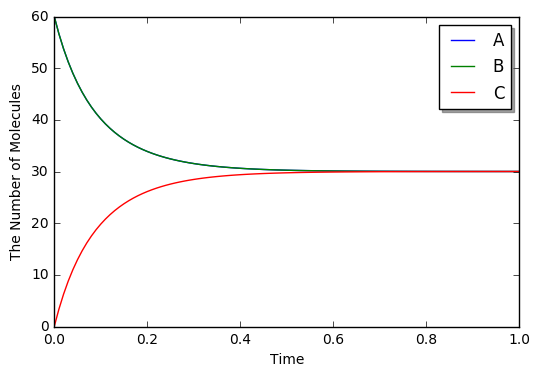

In [12]:
run_simulation(1.0, model=m1, y0={'A': 60, 'B': 60})

Modeling with Python decorators is also available by specifying a function instead of a rate (floating number). When a floating number is set, it is assumed to be a kinetic rate of a mass action reaction, but not a constant velocity.

In [13]:
with reaction_rules():
    A + B == C | (lambda r, *args: 0.1 * reduce(mul, r), 3.0)

m1 = get_model()

For the simplicity, you can directory defining the equation with `Species` names as follows:

In [14]:
with reaction_rules():
    A + B == C | (0.1 * A * B, 3.0)

m1 = get_model()

When you call a `Species` (in the rate law) which is not listed as a reactant or product, it is automatically added to the list as an enzyme.

In [15]:
with reaction_rules():
    S > P | 1.0 * E * S / (30.0 + S)

m1 = get_model()
print(m1.reaction_rules()[0].as_string())

S+E>P+E|((1.0*E*S)/(30.0+S))


where `E` in the equation is appended to both reacant and product lists.

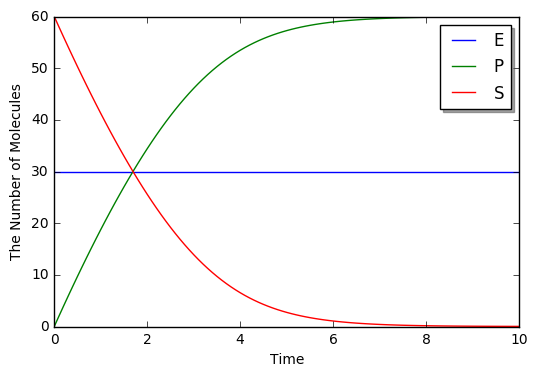

In [16]:
run_simulation(10.0, model=m1, y0={'S': 60, 'E': 30})

Please be careful about typo in `Species`' name. When you make a typo, it is unintentionally recognized as a new enzyme:

In [17]:
with reaction_rules():
    A13P2G > A23P2G | 1500 * A13B2G  # typo: A13P2G -> A13B2G

m1 = get_model()
print(m1.reaction_rules()[0].as_string())

A13P2G+A13B2G>A23P2G+A13B2G|(1500*A13B2G)


When you want to disable the automatic declaration of enzymes, inactivate `util.decorator.ENABLE_IMPLICIT_DECLARATION`. If its value is `False`, the above case will raise an error:

In [20]:
util.decorator.ENABLE_IMPLICIT_DECLARATION = False

try:
    with reaction_rules():
        A13P2G > A23P2G | 1500 * A13B2G
except RuntimeError as e:
    print(repr(e))

util.decorator.ENABLE_IMPLICIT_DECLARATION = True

RuntimeError('unknown variable [A13B2G] was used.',)


Although E-Cell4 is specialized for a simulation of biochemical reaction network, by using a synthetic reaction rule, ordinary differential equations can be translated intuitively. For example, the Lotka-Volterra equations:

$$\frac{dx}{dt} = Ax - Bxy\\\frac{dy}{dt} = -Cx + Dxy$$

where $A=1.5, B=1, C=3, D=1, x(0)=10, y(0)=5$, are solved as follows:

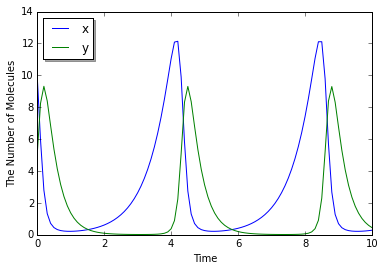

In [19]:
with reaction_rules():
    A, B, C, D = 1.5, 1, 3, 1

    ~x > x | A * x - B * x * y
    ~y > y | -C * y + D * x * y

run_simulation(10, model=get_model(), y0={'x': 10, 'y': 5})

## 6.4. References in a Rate Law

Here, we exlain the details in the rate law definition.

First, when you use simpler definitions of a rate law with `Species`, only a limited number of mathematical functions (e.g. `exp`, `log`, `sin`, `cos`, `tan`, `asin`, `acos`, `atan`, and `pi`) are available there even if you declare the function outside the block.

In [20]:
try:
    from math import erf

    with reaction_rules():
        S > P | erf(S / 30.0)
except TypeError as e:
    print(repr(e))

TypeError('a float is required',)


This is because `erf` is tried to be evaluated agaist `S / 30.0` first, but it is not a floating number. In contrast, the following case is acceptable:

In [21]:
from math import erf

with reaction_rules():
    S > P | erf(2.0) * S

m1 = get_model()
print(m1.reaction_rules()[0].as_string())

S>P|(0.995322265019*S)


where only the result of `erf(2.0)`, `0.995322265019`, is passed to the rate law. Thus, the rate law above has no reference to the `erf` function. Similarly, a value of variables declared outside is acceptable, but not as a reference.

In [22]:
kcat, Km = 1.0, 30.0

with reaction_rules():
    S > P | kcat * E * S / (Km + S)

m1 = get_model()
print(m1.reaction_rules()[0].as_string())
kcat = 2.0
print(m1.reaction_rules()[0].as_string())

S+E>P+E|((1.0*E*S)/(30.0+S))
S+E>P+E|((1.0*E*S)/(30.0+S))


Even if you change the value of a variable, it does **not** affect the rate law.

On the other hand, when you use your own function to define a rate law, it can hold a reference to variables outside.

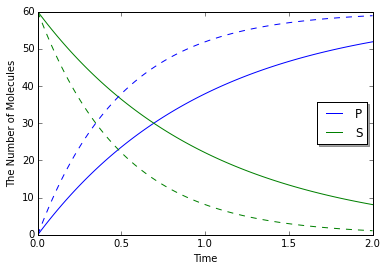

In [23]:
k1 = 1.0

with reaction_rules():
    S > P | (lambda r, *args: k1 * r[0])  # referring k1

m1 = get_model()

obs1 = run_simulation(2, model=m1, y0={"S": 60}, return_type='observer')
k1 = 2.0
obs2 = run_simulation(2, model=m1, y0={"S": 60}, return_type='observer')

viz.plot_number_observer(obs1, '-', obs2, '--')

However, in this case, it is better to make a new model for each set of parameters.

In [24]:
def create_model(k):
    with reaction_rules():
        S > P | k

    return get_model()

obs1 = run_simulation(2, model=create_model(k=1.0), y0={"S": 60}, return_type='observer')
obs2 = run_simulation(2, model=create_model(k=2.0), y0={"S": 60}, return_type='observer')
# viz.plot_number_observer(obs1, '-', obs2, '--')

## 6.5. More about ode

In `ode.ODEWorld`, a value for each `Species` is a floating number. However, for the compatibility, the common member `num_molecules` and `add_molecules` regard the value as an integer.

In [25]:
w = ode.ODEWorld()
w.add_molecules(Species("A"), 2.5)
print(w.num_molecules(Species("A")))

2


To set/get a real number, use `set_value` and `get_value`:

In [26]:
w.set_value(Species("B"), 2.5)
print(w.get_value(Species("A")))
print(w.get_value(Species("B")))

2.0
2.5


As a default, `ode.ODESimulator` employs the Rosenblock method, called `ROSENBROCK4_CONTROLLER`, to solve ODEs. In addition to that, two solvers, `EULER` and `RUNGE_KUTTA_CASH_KARP54`, are available. `ROSENBROCK4_CONTROLLER` and `RUNGE_KUTTA_CASH_KARP54` adaptively change the step size during time evolution due to error controll, but `EULER` does not.

In [27]:
with reaction_rules():
    A > ~A | 1.0

m1 = get_model()

w1 = ode.ODEWorld()
w1.set_value(Species("A"), 1.0)
sim1 = ode.ODESimulator(m1, w1, ode.EULER)
sim1.set_dt(0.01) # This is only effective for EULER
sim1.run(3.0, obs1)

`ode.ODEFactory` also accepts a solver type and a default step interval.

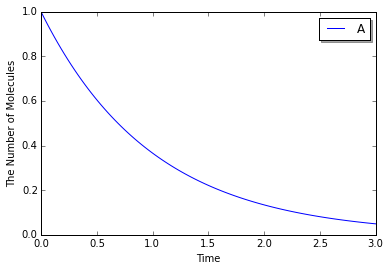

In [28]:
run_simulation(3.0, model=m1, y0={"A": 1.0}, solver=('ode', ode.EULER, 0.01))

See also examples listed below:

* [Glycolysis of Human Erythrocytes](../Examples/Glycolysis of Human Erythrocytes.ipynb)
* [Drosophila Circadian Clock](../Examples/Drosophila Circadian Clock.ipynb)
* [Attractors](../Examples/Attractors.ipynb)